In [1]:
from random import randint
import matplotlib.pyplot as plt

## Constants

In [19]:
#P = some prime number greater than alphabet size, MOD = some huge prime number, ALPHABET = alphabet size
P = 257
MOD = int(1e9) + 9
ALPHABET = 256

## KMP

In [3]:
def makePi(pat):
    """
    Params: pattern, text
    Return: PI table, KMP algorithm
    """
    size, i = 0, 1
    n = len(pat)
    
    pi = [0]*n
    
    while i < n:
        if pat[i] == pat[size]:
            size += 1
            pi[i] = size
            i += 1
        else:
            if size != 0:
                size = pi[size-1]
            else:
                pi[i] = 0
                i += 1
    
    return pi

In [4]:
def kmp(pat, text):
    """
    Knuth-Morris-Pratt Algorithm
    Params: pattern, text
    Return: indexes of pattern matches using the PI table
    """
    m, n = len(pat), len(text)
    i, j = 0, 0
    
    pi = makePi(pat)
    
    idxs = []
    while i < n:
        if pat[j] == text[i]:
            i, j = i+1, j+1
        if j == m:
            idxs.append(i-j)
            j = pi[j-1]
        elif i < n and pat[j] != text[i]:
            if j != 0: 
                j = pi[j-1] 
            else: 
                i = i+1
    
    #print(idxs)
    return idxs

## Boyer-Moore

In [5]:
def badChar(pat):
    """
    Params: pattern
    Return: BadCharacter table, Boyer-Moore Algorithm
    """
    n = len(pat)
    shift = [n]*ALPHABET
    
    for i in range(n-1):
        shift[ord(pat[i])] = n - i -1
    
    return shift

In [6]:
def bms(pat, text):
    """
    Boyer-Moore Algorithm
    Params: pattern, text
    Return: indexes of pattern matches, comparisson from right to left
    """
    m, n = len(pat), len(text)
    
    shiftTable = badChar(pat)
    
    i = m-1
    
    idxs = []
    while i < n:
        j = 0
        while j < m and text[i-j] == pat[m-j-1]: 
            j+=1
        if j == m: 
            idxs.append(i-m+1)
        i = i + shiftTable[ord(text[i])]
    
    #print(idxs)
    return idxs

## Rabin-Karp

In [7]:
"""
Reference of optimizations: 
    https://cp-algorithms.com/string/string-hashing.html
    https://cp-algorithms.com/string/rabin-karp.html
"""
def stringHash(pat, text):   
    s, t = len(pat),len(text)
    prime_pow = [1]*max(s, t)
    
    for i in range(1,len(prime_pow)):
        prime_pow[i] = (prime_pow[i-1] * P) % MOD
        
    sHash = 0
    for i in range(s):
        sHash = (sHash + (ord(pat[i]) - ord('A') + 1) * prime_pow[i]) % MOD
    
    return sHash, prime_pow

In [8]:
def rabin_karp(pat, text):
    """
    Rabin-Karp Algorithm
    Params: pattern, text
    Return: indexes of pattern matches, based on rolling hash
    """
    #sHash = hash of pattern, tHash = rolling hash of text, pPow pre-computed prime pow
    sHash, pPow = stringHash(pat, text)
    
    s, t = len(pat),len(text)
    
    tHash = [0] * (t+1)
    for i in range(t):
        tHash[i+1] = (tHash[i] + (ord(text[i]) - ord('A') + 1) * pPow[i]) % MOD
    
    idxs = []
    i = 0
    while i+s-1 < t:
        cur_h = (tHash[i+s] + MOD - tHash[i]) % MOD
        
        if cur_h == (sHash * pPow[i] % MOD):
            #if pat == text[i:i+s]:
            idxs.append(i)
        
        i+=1

    #print(idxs)
    return idxs    

# Testes

In [9]:
text = 'ABABDABACDABABCABAB'
pat = 'ABABCABAB'

#test = %timeit -o kmp(pat, text)
#kmp(pat, text)

#%timeit bms(pat, text)
#bms(pat, text)

#%timeit rabin_karp(pat, text)
#rabin_karp(pat, text)

In [10]:
ls datasets/

26-char.txt  62-char.txt   wiki_movie_plots_deduped.csv
36-char.txt  94-char.txt   wikipedia_text.txt
52-char.txt  rng_text.txt  worst_case.txt


60M characters text

In [11]:
t_kmp = {'f':[[] for _ in range(5)],'nf':[[] for _ in range(5)]}
t_bms = {'f':[[] for _ in range(5)],'nf':[[] for _ in range(5)]}
t_rk = {'f':[[] for _ in range(5)],'nf':[[] for _ in range(5)]}

In [12]:
size = 10000000
for txt in ['wikipedia_text', 'rng_text', 'worst_case']:
    text = open(f'datasets/{txt}.txt','r').readlines()
    text = ''.join(text)
    print(f'txt = {txt}')
    for i, sz in enumerate([10,100,1000,10000,100000]):
        init = randint(size-sz*9,size-sz)
        f_pat = text[init:init+sz]
        nf_pat = 'a'*sz
        print(f'lengh of pattern = {sz}')
        f_kmp = %timeit -o kmp(f_pat,text)
        nf_kmp = %timeit -o kmp(nf_pat, text)
        t_kmp['f'][i].append([f_kmp.average,f_kmp.stdev])
        t_kmp['nf'][i].append([nf_kmp.average,nf_kmp.stdev])
        
        f_bms = %timeit -o bms(f_pat,text)
        nf_bms = %timeit -o bms(nf_pat, text)
        t_bms['f'][i].append([f_bms.average,f_bms.stdev])
        t_bms['nf'][i].append([nf_bms.average,nf_bms.stdev])
        
        f_rk = %timeit -o rabin_karp(f_pat,text)
        nf_rk = %timeit -o rabin_karp(nf_pat, text)
        t_rk['f'][i].append([f_rk.average,f_rk.stdev])
        t_rk['nf'][i].append([nf_rk.average,nf_rk.stdev])
    

txt = wikipedia_text
lengh of pattern = 10
2.55 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.49 s ± 4.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
404 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
341 ms ± 804 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.9 s ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.9 s ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
lengh of pattern = 100
2.41 s ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.48 s ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
132 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
34.6 ms ± 72.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
11.9 s ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.9 s ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
lengh of pattern = 1000
2.43 s ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.52 s ± 31.1 ms per loo

KeyboardInterrupt: 

In [14]:
t_kmp

{'f': [[[2.551586711429991, 0.13633458327275472],
   [2.4102933187095914, 0.0008356545508837989],
   [2.9283460639957672, 0.002850824201910716]],
  [[2.414752305568462, 0.019251749024695675],
   [2.40975585785262, 0.0015089626828903684],
   [2.919741798279574, 0.0012383355337302216]],
  [[2.4257663232898006, 0.0014603208918048589],
   [2.4097781335752058, 0.0007799816863228059],
   [3.1826498117090005, 0.0013980862210796927]],
  [[2.429303511569742, 0.007192186011781916],
   [2.411532997860507, 0.0010871040417492963],
   [3.191765936000073, 0.003998256965336354]],
  [[2.502073027426377, 0.0474477257056468],
   [2.4275609089984624, 0.0037607601085437596]]],
 'nf': [[[2.4884718447075493, 0.00441646594400837],
   [2.4113803862918366, 0.00404110508734424],
   [2.934795264283561, 0.015927423883905664]],
  [[2.484111083563351, 0.0024286679987182693],
   [2.4120453744336765, 0.0038099094798561815],
   [2.920746764421762, 0.002450363947574264]],
  [[2.5157550824307173, 0.0311342516857238],
   

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

In [249]:
f_kmp, n_kmp = [], []
for el in t_kmp['f']:
    for x in el:
        f_kmp.append(x[0])

for el in t_kmp['nf']:
    for x in el:
        n_kmp.append(x[0])

#f_kmp, n_kmp = f_kmp[:12], n_kmp[:12]



f_bms, n_bms = [], []
for el in t_bms['f']:
    for x in el:
        f_bms.append(x[0])

for el in t_bms['nf']:
    for x in el:
        n_bms.append(x[0])

#f_bms, n_bms = f_bms[:-4], n_bms[:-4]



f_rk, n_rk = [], []
for el in t_rk['f']:
    for x in el:
        f_rk.append(x[0])

for el in t_rk['nf']:
    for x in el:
        n_rk.append(x[0])
        
#f_rk, n_rk = f_rk[:12], n_rk[:12]

In [139]:
colors = ['red','green','blue']
xs = [10,100,1000,10000]
#sizes of patt = 10,100,1000,10000

In [250]:
wiki = {}
wiki['KMP'] = [f_kmp[i] for i in range(0,12,3)]
wiki['Boyer-Moore'] = [f_bms[i] for i in range(0,12,3)]
wiki['Rabin-Karp'] = [f_rk[i] for i in range(0,12,3)]
#wiki['x'] = list(range(4))
#wiki['patt'] = xs
wiki_df = pd.DataFrame(wiki,index=xs)

rng = {}
rng['KMP'] = [f_kmp[i] for i in range(1,12,3)]
rng['Boyer-Moore'] = [f_bms[i] for i in range(1,12,3)]
rng['Rabin-Karp'] = [f_rk[i] for i in range(1,12,3)]
rng_df = pd.DataFrame(rng,index=xs)


worst = {}
worst['KMP'] = [f_kmp[i] for i in range(2,12,3)]
worst['Boyer-Moore'] = [f_bms[i] for i in range(2,12,3)]
worst['Rabin-Karp'] = [f_rk[i] for i in range(2,12,3)]
worst_df = pd.DataFrame(worst,index=xs)

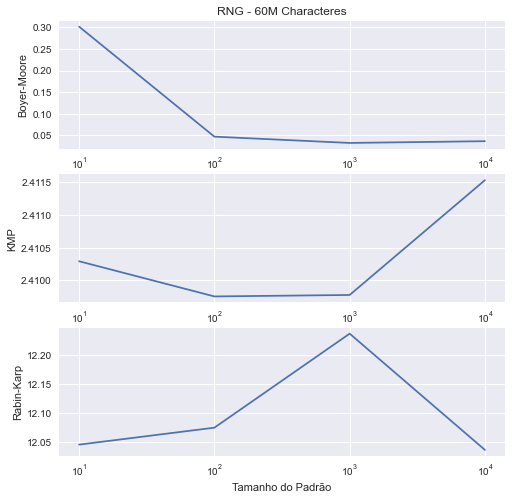

In [254]:
fig, axs = plt.subplots(3,1,figsize=(8,8))
sns.lineplot(data=rng_df,y='Boyer-Moore',x=rng_df.index,ax=axs[0])
sns.lineplot(data=rng_df,y='KMP',x=wiki_df.index,ax=axs[1])
sns.lineplot(data=rng_df,y='Rabin-Karp',x=rng_df.index,ax=axs[2])
axs[2].set_xlabel('Tamanho do Padrão')
axs[0].set_title('RNG - 60M Characteres')
for i in range(3):
    axs[i].set(xscale="log")

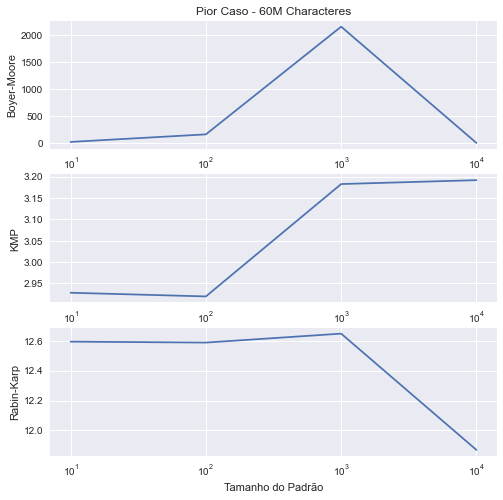

In [255]:
fig, axs = plt.subplots(3,1,figsize=(8,8))
sns.lineplot(data=worst_df,y='Boyer-Moore',x=worst_df.index,ax=axs[0])
sns.lineplot(data=worst_df,y='KMP',x=worst_df.index,ax=axs[1])
sns.lineplot(data=worst_df,y='Rabin-Karp',x=worst_df.index,ax=axs[2])
axs[2].set_xlabel('Tamanho do Padrão')
axs[0].set_title('Pior Caso - 60M Characteres')
for i in range(3):
    axs[i].set(xscale="log")

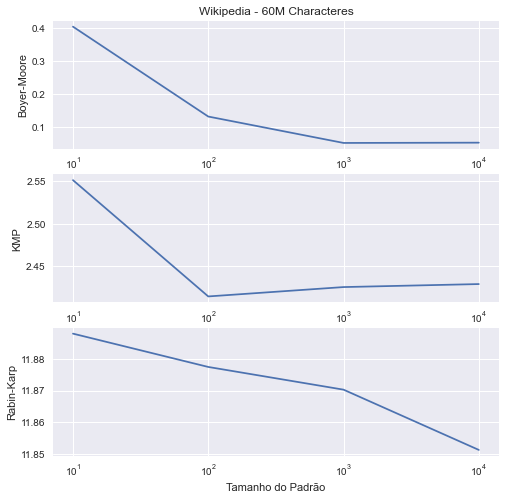

In [256]:
fig, axs = plt.subplots(3,1,figsize=(8,8))
sns.lineplot(data=wiki_df,y='Boyer-Moore',x=wiki_df.index,ax=axs[0])
sns.lineplot(data=wiki_df,y='KMP',x=wiki_df.index,ax=axs[1])
sns.lineplot(data=wiki_df,y='Rabin-Karp',x=wiki_df.index,ax=axs[2])
axs[2].set_xlabel('Tamanho do Padrão')
axs[0].set_title('Wikipedia - 60M Characteres')
for i in range(3):
    axs[i].set(xscale="log")

In [16]:
t_kmp2 = {'f':[[] for _ in range(5)],'nf':[[] for _ in range(5)]}
t_bms2 = {'f':[[] for _ in range(5)],'nf':[[] for _ in range(5)]}
t_rk2 = {'f':[[] for _ in range(5)],'nf':[[] for _ in range(5)]}

In [20]:
size = 1000000
for txt in [26,36,52,62,94]:
    text = open(f'datasets/{txt}-char.txt','r').readlines()
    text = ''.join(text)
    print(f'txt = {txt}-char-alphabet')
    for i, sz in enumerate([10,100,1000,10000]):        
        init = randint(size-sz*9,size-sz)
        f_pat = text[init:init+sz]
        nf_pat = 'a'*sz
        
        print(f'lengh of pattern = {sz}')
        f_kmp = %timeit -o kmp(f_pat,text)
        nf_kmp = %timeit -o kmp(nf_pat, text)
        t_kmp2['f'][i].append([f_kmp.average,f_kmp.stdev])
        t_kmp2['nf'][i].append([nf_kmp.average,nf_kmp.stdev])
        
        f_bms = %timeit -o bms(f_pat,text)
        nf_bms = %timeit -o bms(nf_pat, text)
        t_bms2['f'][i].append([f_bms.average,f_bms.stdev])
        t_bms2['nf'][i].append([nf_bms.average,nf_bms.stdev])
        
        f_rk = %timeit -o rabin_karp(f_pat,text)
        nf_rk = %timeit -o rabin_karp(nf_pat, text)
        t_rk2['f'][i].append([f_rk.average,f_rk.stdev])
        t_rk2['nf'][i].append([nf_rk.average,nf_rk.stdev])
    

txt = 26-char-alphabet
lengh of pattern = 10
256 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
245 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
33.8 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.3 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.25 s ± 5.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.24 s ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
lengh of pattern = 100
246 ms ± 4.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
246 ms ± 3.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.3 ms ± 31.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.07 ms ± 3.04 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.25 s ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.25 s ± 3.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
lengh of pattern = 1000
247 ms ± 4.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
252 ms ± 2.65

508 µs ± 5.32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.45 s ± 5.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.45 s ± 4.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
lengh of pattern = 10000
277 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
284 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7.87 ms ± 84.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.55 ms ± 5.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.45 s ± 3.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.46 s ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [193]:
f_kmp, n_kmp = [], []
for el in t_kmp2['f']:
    for x in el:
        f_kmp.append(x[0])

for el in t_kmp2['nf']:
    for x in el:
        n_kmp.append(x[0])

#f_kmp, n_kmp = f_kmp[:12], n_kmp[:12]



f_bms, n_bms = [], []
for el in t_bms2['f']:
    for x in el:
        f_bms.append(x[0])

for el in t_bms2['nf']:
    for x in el:
        n_bms.append(x[0])

#f_bms, n_bms = f_bms[:-4], n_bms[:-4]



f_rk, n_rk = [], []
for el in t_rk2['f']:
    for x in el:
        f_rk.append(x[0])

for el in t_rk2['nf']:
    for x in el:
        n_rk.append(x[0])
    
#f_rk, n_rk = f_rk[:12], n_rk[:12]

In [241]:
#[26,36,52,62,94] || [10,100,1000,10000]
kmp_dict = {}
kmp_dict['26'] = [f_kmp[i] for i in range(0,4)]
kmp_dict['36'] = [f_kmp[i] for i in range(4,8)]
kmp_dict['52'] = [f_kmp[i] for i in range(8,12)]
kmp_dict['62'] = [f_kmp[i] for i in range(12,16)]
kmp_dict['94'] = [f_kmp[i] for i in range(16,20)]
kmp_df = pd.DataFrame(kmp_dict,index=xs)

kmp_dict2 = {}
kmp_dict2['26'] = [n_kmp[i] for i in range(0,4)]
kmp_dict2['36'] = [n_kmp[i] for i in range(4,8)]
kmp_dict2['52'] = [n_kmp[i] for i in range(8,12)]
kmp_dict2['62'] = [n_kmp[i] for i in range(12,16)]
kmp_dict2['94'] = [n_kmp[i] for i in range(16,20)]
kmp_df2 = pd.DataFrame(kmp_dict2,index=xs)

bms_dict = {}
bms_dict['26'] = [f_bms[i] for i in range(0,4)]
bms_dict['36'] = [f_bms[i] for i in range(4,8)]
bms_dict['52'] = [f_bms[i] for i in range(8,12)]
bms_dict['62'] = [f_bms[i] for i in range(12,16)]
bms_dict['94'] = [f_bms[i] for i in range(16,20)]
bms_df = pd.DataFrame(bms_dict,index=xs)

bms_dict2 = {}
bms_dict2['26'] = [n_bms[i] for i in range(0,4)]
bms_dict2['36'] = [n_bms[i] for i in range(4,8)]
bms_dict2['52'] = [n_bms[i] for i in range(8,12)]
bms_dict2['62'] = [n_bms[i] for i in range(12,16)]
bms_dict2['94'] = [n_bms[i] for i in range(16,20)]
bms_df2 = pd.DataFrame(bms_dict2,index=xs)

rk_dict = {}
rk_dict['26'] = [f_rk[i] for i in range(0,4)]
rk_dict['36'] = [f_rk[i] for i in range(4,8)]
rk_dict['52'] = [f_rk[i] for i in range(8,12)]
rk_dict['62'] = [f_rk[i] for i in range(12,16)]
rk_dict['94'] = [f_rk[i] for i in range(16,20)]
rk_df = pd.DataFrame(rk_dict,index=xs)

rk_dict2 = {}
rk_dict2['26'] = [n_rk[i] for i in range(0,4)]
rk_dict2['36'] = [n_rk[i] for i in range(4,8)]
rk_dict2['52'] = [n_rk[i] for i in range(8,12)]
rk_dict2['62'] = [n_rk[i] for i in range(12,16)]
rk_dict2['94'] = [n_rk[i] for i in range(16,20)]
rk_df2 = pd.DataFrame(rk_dict2,index=xs)

In [210]:
kmp_df

,26,36,52,62,94
10,0.255392,0.258170,0.245760,0.246772,0.276964
100,0.251386,0.278034,0.274514,0.243904,0.247642
1000,0.255533,0.277637,0.277081,0.294830,0.246568
10000,0.245564,0.246172,0.278194,0.279787,0.284890


Text(0.5, 0.98, 'KMP')

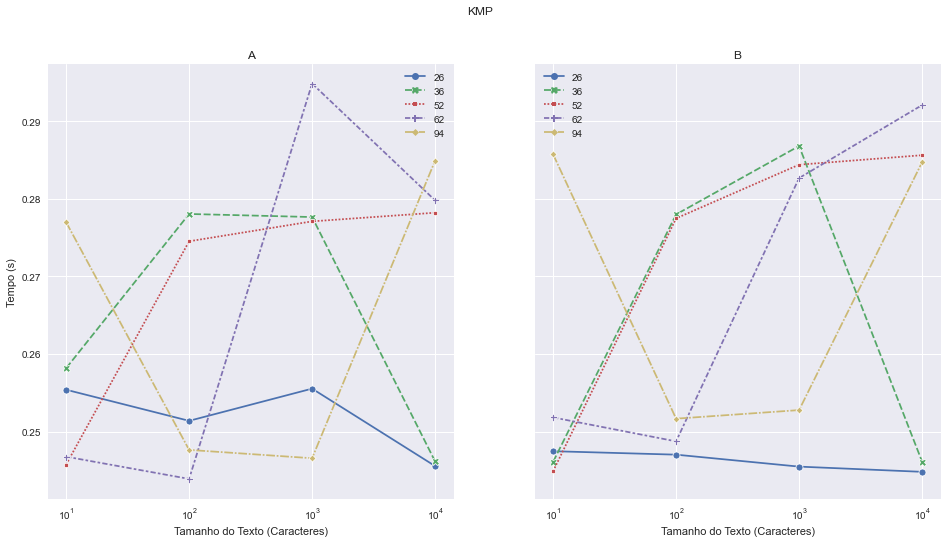

In [246]:
fig, axs = plt.subplots(1,2,figsize=(16,8),sharey=True)
sns.lineplot(data=kmp_df,markers=True,ax=axs[0])
axs[0].set(xscale='log')
axs[0].set_title('A')
axs[0].set_xlabel('Tamanho do Padrão (Caracteres)')
axs[0].set_ylabel('Tempo (s)')

sns.lineplot(data=kmp_df2,markers=True,ax=axs[1])
axs[1].set(xscale='log')
axs[1].set_title('B')
axs[1].set_xlabel('Tamanho do Padrão (Caracteres)')
axs[1].set_ylabel('Tempo (s)')

fig.suptitle('KMP - 10M Caracteres')

Text(0.5, 0.98, 'Boyer-Moore')

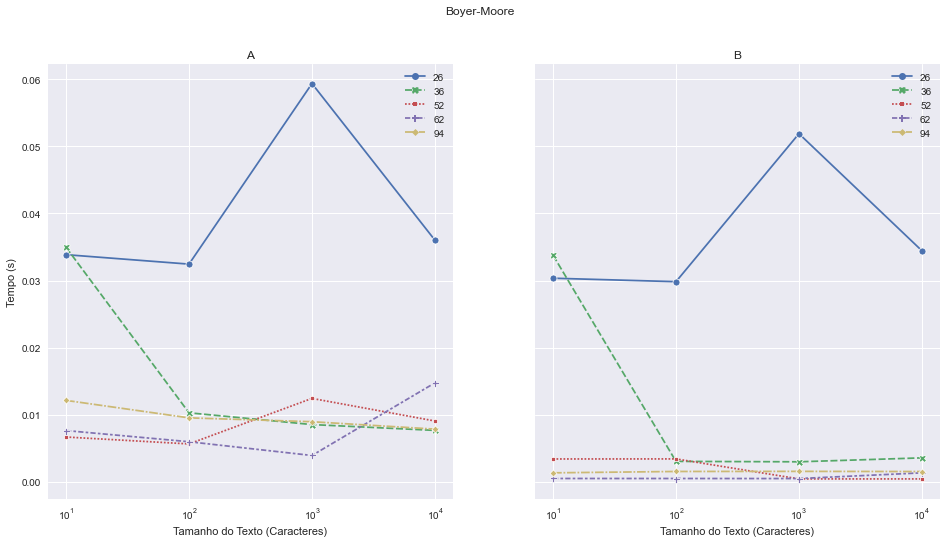

In [248]:
fig, axs = plt.subplots(1,2,figsize=(16,8),sharey=True)
sns.lineplot(data=bms_df,markers=True,ax=axs[0])
axs[0].set(xscale='log')
axs[0].set_title('A')
axs[0].set_xlabel('Tamanho do Padrão (Caracteres)')
axs[0].set_ylabel('Tempo (s)')

sns.lineplot(data=bms_df2,markers=True,ax=axs[1])
axs[1].set(xscale='log')
axs[1].set_title('B')
axs[1].set_xlabel('Tamanho do Padrão (Caracteres)')
axs[1].set_ylabel('Tempo (s)')

fig.suptitle('Boyer-Moore - 10M Caracteres')

Text(0.5, 0.98, 'Rabin-Karp')

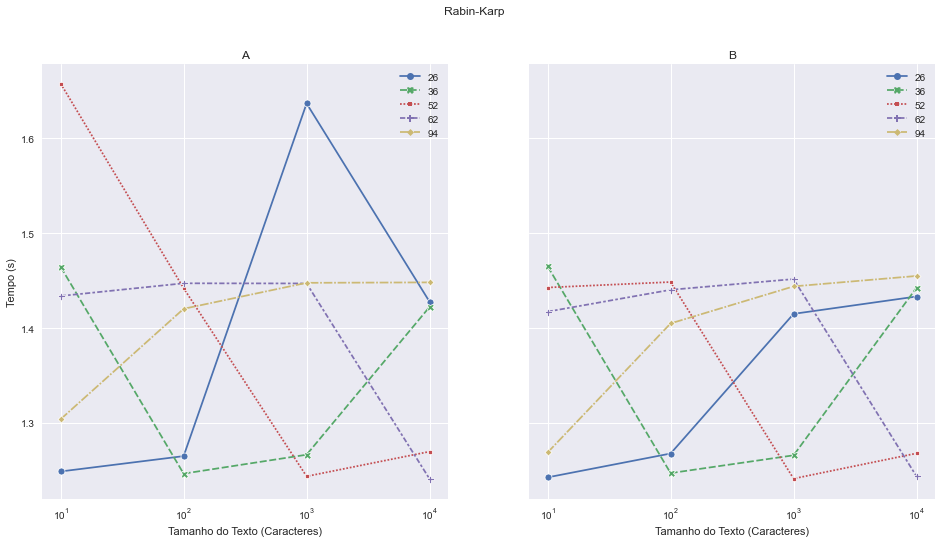

In [247]:
fig, axs = plt.subplots(1,2,figsize=(16,8),sharey=True)
sns.lineplot(data=rk_df,markers=True,ax=axs[0])
axs[0].set(xscale='log')
axs[0].set_title('A')
axs[0].set_xlabel('Tamanho do Padrão (Caracteres)')
axs[0].set_ylabel('Tempo (s)')

sns.lineplot(data=rk_df2,markers=True,ax=axs[1])
axs[1].set(xscale='log')
axs[1].set_title('B')
axs[1].set_xlabel('Tamanho do Padrão (Caracteres)')
axs[1].set_ylabel('Tempo (s)')

fig.suptitle('Rabin-Karp - 10M Caracteres')